In [1]:
from MOT import MOT
import numpy as np
import matplotlib.pyplot as plt
import os
from BfTableGenerator import RansacCollector
from BfTableGenerator import TDmapLoader
from tqdm import tqdm
# from open3d import JVisualizer 
from Utils import *
from DDBSCAN import Raster_DBSCAN
import open3d as op3
# op3.visualization.webrtc_server.enable_webrtc()
from open3d.web_visualizer import draw
from VisulizerTools import *
from numpy.lib.stride_tricks import sliding_window_view
from scipy.stats import multivariate_normal
from tqdm import tqdm_notebook
import time


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
def get_thred_modified(ts,d ,thred_s ,N ,delta_thred ,step):# Ransac Para
    ts_temp = ts.copy()
    ts_temp[ts_temp == 0] = 1000
    valid_dises = []
    for i in range(N):
        sample = np.random.choice(ts_temp,replace=False)
        set_d = ts_temp[(ts_temp > sample - d)&(ts_temp < sample + d)]
        condition_thred = len(set_d)/len(ts_temp) > thred_s
        if condition_thred :
            valid_dises.append(sample)
            
    if len(valid_dises) == 0:
        return 1000

    cur_thred = np.min(valid_dises)

    while True:
        next_thred = cur_thred - step
        if (len(ts[ts > next_thred])/len(ts) - len(ts[ts > cur_thred])/len(ts)) < delta_thred:
            break
        cur_thred = next_thred

    return next_thred

In [3]:
def get_thred(ts,d ,thred_s ,N ,delta_thred ,step ):# Ransac Para
    ts_temp = ts.copy()
    ts_temp[ts_temp == 0] = 1000

    flag = True                             
    for i in range(N):
        sample = np.random.choice(ts_temp,replace=False)
        if len(ts_temp[(ts_temp > sample - d)&(ts_temp < sample + d)])/len(ts_temp) > thred_s:
            flag = False
            break
    if flag:
        return 1000
    cur_thred = sample
    while True:
        next_thred = cur_thred - step
        if (len(ts_temp[ts_temp > next_thred])/len(ts) - len(ts_temp[ts_temp > cur_thred])/len(ts)) < delta_thred:
            break
        cur_thred = next_thred
    return next_thred

In [4]:
collector_0 = RansacCollector(pcap_path=r'D:\LiDAR_Data\MidTown\California\2021-12-9-11-30-0.pcap',output_file_path='D:\LiDAR_Data\MidTown\California',update_frame_num=500)
collector_0.gen_tdmap()

Loading pcap...


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:17<00:00, 28.03it/s]


In [100]:
# %%timeit
d = 0.5
thred_s = 0.25
N = 20
delta_thred = 1e-3
step = 0.1
aggregated_maps_temp = aggregated_map
threshold_map = np.zeros((32,1800))
print('Generating Threshold Map')
for i in range(32):
    for j in range(1800):
        t_s = aggregated_maps_temp[:,i,j].copy()
        threshold_value = get_thred_modified(t_s,d,thred_s,N,delta_thred,step)
        threshold_map[i,j] = threshold_value


Generating Threshold Map


In [123]:
np.save(r'D:\LiDAR_Data\MidTown\California\test_thred_map.npy',threshold_map)

In [6]:
threshold_map = np.load(r'D:\LiDAR_Data\MidTown\California\bck_map.npy')

In [9]:
aggregated_maps_temp = collector_0.aggregated_map

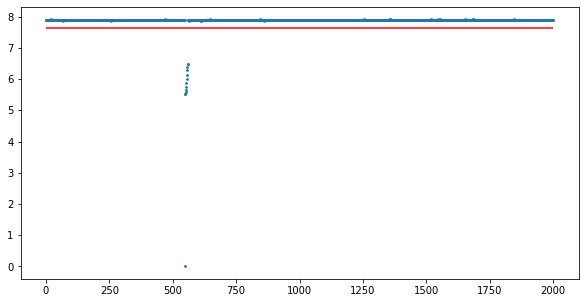

In [10]:
laser_id = theta_raw[0] == theta
azimuth_channel = np.around((16980/100)/0.2).astype('int')
plt.figure(figsize=(10,5))
plt.scatter(np.arange(2000),aggregated_maps_temp[:2000,laser_id,azimuth_channel], s = 3)
plt.hlines(threshold_map[laser_id,azimuth_channel],0,2000,color = 'r')
plt.show()

In [5]:
db = Raster_DBSCAN(window_size=(5,13),eps = 1.2, min_samples= 8, Td_map_szie=threshold_map.shape)   
Td_map = collector_0.aggregated_map[444]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [35]:
from sklearn.cluster._dbscan_inner import dbscan_inner
from numpy.lib.stride_tricks import sliding_window_view


In [6]:
eps = 1.2
min_samples = 8

In [7]:
window_size = (5,13)
Height_fringe = int(window_size[0]/2) 
Width_fringe = int(window_size[1]/2) # azimuth
Td_map_szie = (32,1800)
Height_fringe_offset_fore = np.full((Height_fringe,Td_map_szie[1] + 2 * Width_fringe),False) 
Height_fringe_offset_td = np.full((Height_fringe,Td_map_szie[1] + 2 * Width_fringe),200) 

Heigh_fringe_offset_index = np.full((Height_fringe,Td_map_szie[1] + 2 * Width_fringe),-1,dtype = np.int64) 



rows,cols = np.where(Foreground_map)
indices = np.arange(len(rows),dtype = np.int64)
Index_map = -1*np.ones(shape = Foreground_map.shape,dtype=np.int64)
Index_map[rows,cols] = indices 
Foreground_map_offset = np.concatenate([Foreground_map[:,-Width_fringe:],
                                        Foreground_map,
                                        Foreground_map[:,:Width_fringe]],axis = 1)
Index_map_offset = np.concatenate([Index_map[:,-Width_fringe:],
                                Index_map,
                                Index_map[:,:Width_fringe]],axis = 1)
Td_map_offset = np.concatenate([Td_map[:,-Width_fringe:],
                                Td_map,
                                Td_map[:,:Width_fringe]],axis = 1)
Foreground_map_offset = np.concatenate([Height_fringe_offset_fore,
                                        Foreground_map_offset,
                                    Height_fringe_offset_fore])
Index_map_offset = np.concatenate([Heigh_fringe_offset_index,
                                Index_map_offset,
                                Heigh_fringe_offset_index])
Td_map_offset = np.concatenate([Height_fringe_offset_td,
                            Td_map_offset,
                            Height_fringe_offset_td])
Sub_indmap = sliding_window_view(Index_map_offset,window_size).reshape(-1,window_size[0],window_size[1])
Sub_tdmap = sliding_window_view(Td_map_offset,window_size).reshape(-1,window_size[0],window_size[1])
Sub_foremap = sliding_window_view(Foreground_map_offset,window_size).reshape(-1,window_size[0],window_size[1])
valid_windows = Sub_foremap[:,Height_fringe,Width_fringe] 
Sub_indmap,Sub_foremap,Sub_tdmap = Sub_indmap[valid_windows],Sub_foremap[valid_windows],Sub_tdmap[valid_windows]
center_td_dist = Sub_tdmap[:,Height_fringe,Width_fringe]
temp = ((np.abs((Sub_tdmap - center_td_dist.reshape(-1,1,1))) < eps) & Sub_foremap)
neighborhoods = np.array([Sub_indmap[i][temp[i]] for i in range(len(temp))],dtype = 'O')
n_neighbors = np.array([len(neighbor) for neighbor in neighborhoods])
Labels = np.full(len(n_neighbors), -1, dtype=np.intp)
core_samples = np.asarray(n_neighbors >= min_samples,dtype=np.uint8)
dbscan_inner(core_samples, neighborhoods, Labels)
Labeling_map = -1*np.ones_like(Foreground_map)

Labeling_map[rows,cols] = Labels

NameError: name 'Foreground_map' is not defined

In [95]:
for n in neighborhoods:
    if -1 in n:
        print(n)

In [113]:
np.where(Labeling_map == 1)

(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 array([1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032,
        1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
        1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1055,
        1057, 1058], dtype=int64))

In [85]:
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_4')

In [72]:
db = Raster_DBSCAN(window_size=(5,11),eps = 1.2, min_samples= 8, Td_map_szie=threshold_map.shape)   
Td_map = collector_0.aggregated_map[480]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored(Td_map,Labeling_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_12')

In [59]:
#points_num,dir_vec[0],dir_vec[1],height,length,width,area

In [75]:
1.5*10*3600/1000

54.0

In [67]:
for i in range(440,450):
    Td_map = collector_0.aggregated_map[i]
    Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
    Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
    mea_init,app_init,unique_label_init,Labeling_map = extract_xy(Labeling_map,Td_map)
    aa = mea_init[:,0,:][1]
    print(11111111111111111)
    print(aa)
    print(app_init[1])
    print(11111111111111111)

11111111111111111
[[-3.16584038]
 [ 5.85509929]]
[[40.        ]
 [ 0.85096675]
 [ 0.52521956]
 [ 0.5614742 ]
 [ 0.49167418]
 [ 0.23493883]
 [ 0.11551335]]
11111111111111111
11111111111111111
[[-3.13972266]
 [ 5.80679558]]
[[37.        ]
 [ 0.94609886]
 [ 0.3238779 ]
 [ 0.52325126]
 [ 0.46854839]
 [ 0.20873819]
 [ 0.09780394]]
11111111111111111
11111111111111111
[[-3.25294406]
 [ 5.63426439]]
[[38.        ]
 [ 0.96874774]
 [ 0.24804823]
 [ 0.55972496]
 [ 0.60295099]
 [ 0.19803393]
 [ 0.11940476]]
11111111111111111
11111111111111111
[[-3.1621488 ]
 [ 5.43311562]]
[[42.        ]
 [ 0.98237354]
 [ 0.18692841]
 [ 0.54326485]
 [ 0.57466346]
 [ 0.21806376]
 [ 0.12531327]]
11111111111111111
11111111111111111
[[-3.04494053]
 [ 5.27399171]]
[[40.        ]
 [ 0.90338159]
 [ 0.42883766]
 [ 0.53288094]
 [ 0.55340946]
 [ 0.22039677]
 [ 0.12196966]]
11111111111111111
11111111111111111
[[-2.91390865]
 [ 5.17135476]]
[[37.        ]
 [ 0.68691242]
 [ 0.72674024]
 [ 0.50632251]
 [ 0.52026373]
 [ 0.228784

In [60]:
mea_init,app_init,unique_label_init,Labeling_map = extract_xy(Labeling_map,Td_map)

In [61]:
unique_label_init

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
      dtype=int64)

In [62]:
app_init[1]

array([[40.        ],
       [ 0.85096675],
       [ 0.52521956],
       [ 0.5614742 ],
       [ 0.49167418],
       [ 0.23493883],
       [ 0.11551335]])

In [63]:
np.where(Labeling_map == 1)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 array([1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669,
        1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1658,
        1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669,
        1670, 1671, 1672, 1673, 1674, 1675, 1676], dtype=int64))

In [64]:
mea_init[:,0,:]

array([[[  -4.30001731],
        [ -10.75081024]],

       [[  -3.16584038],
        [   5.85509929]],

       [[  -0.91102581],
        [ -17.383408  ]],

       [[  -0.89888498],
        [ -28.60298374]],

       [[ -13.54450501],
        [ -16.72607072]],

       [[  12.52987651],
        [ -69.63812581]],

       [[ -23.25336259],
        [   2.77279562]],

       [[   2.81073852],
        [   4.07439744]],

       [[ -27.73935825],
        [ -39.32304702]],

       [[ -29.04497484],
        [ -33.41242144]],

       [[ -16.92556636],
        [  18.66629898]],

       [[  -1.24802858],
        [   3.7959005 ]],

       [[ -44.29354174],
        [ -11.86841874]],

       [[ -39.19844778],
        [  -0.27366124]],

       [[   1.20876002],
        [   3.95367588]],

       [[   1.22214207],
        [   6.28737589]],

       [[ -47.77105811],
        [ -13.51784688]],

       [[ -58.83318599],
        [ -17.53893449]],

       [[ -23.84246592],
        [  25.0370557 ]],

       [[   

In [9]:
np.where(Labeling_map == 1)

(array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2, 27, 28, 28, 30, 30, 30, 30, 30, 31],
       dtype=int64),
 array([1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660,
        1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671,
        1672, 1673, 1674, 1675, 1676, 1655, 1657, 1658, 1659, 1660, 1661,
        1662, 1663, 1664, 1665, 1666, 1667, 1668, 1694, 1688, 1689, 1682,
        1685, 1687, 1688, 1692, 1692], dtype=int64))

In [47]:
mea_init[:,0]

array([[[  -4.29286492],
        [ -10.73292798]],

       [[  -3.04494053],
        [   5.27399171]],

       [[  -0.9073308 ],
        [ -17.31290297]],

       [[ -13.89248412],
        [ -16.32361362]],

       [[   0.55366078],
        [ -31.71920473]],

       [[  12.53340287],
        [ -69.65772451]],

       [[ -21.75432664],
        [   4.07121157]],

       [[ -27.66372156],
        [ -39.5078888 ]],

       [[ -29.04235699],
        [ -33.40940996]],

       [[   2.75336073],
        [   4.17569073]],

       [[ -39.854213  ],
        [ -10.23282268]],

       [[ -17.19890795],
        [  21.39112734]],

       [[ -42.02145412],
        [  -1.3205774 ]],

       [[   0.57413855],
        [   4.96213446]],

       [[   1.05059998],
        [   5.40486835]],

       [[ -53.76136627],
        [ -15.61912076]],

       [[ -23.87555365],
        [  25.07180123]],

       [[ -47.81252   ],
        [  15.90510847]],

       [[-110.4573827 ],
        [ -32.50937564]],

       [[ -2

In [80]:
app_ped[[0,3,4,6]]

array([[46.        ],
       [ 1.20906826],
       [ 0.61952704],
       [ 0.26258078]])

In [29]:
bck_path = r'D:\LiDAR_Data\MidTown\CaliforniaData'
pcaps_list = os.listdir(bck_path)
pcaps_list = [p for p in pcaps_list if 'pcap' in p.split('.')]
aggregated_maps_multiple = []
for i in range(len(pcaps_list)):
    collector = RansacCollector(pcap_path=os.path.join(bck_path,pcaps_list[i]),output_file_path=bck_path,update_frame_num=3000)
    collector.gen_tdmap()
    aggregated_maps_multiple.append(collector.aggregated_map[np.random.choice(np.arange(0,3000),size = 1000 ,replace = False)])

Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:42<00:00, 29.25it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:41<00:00, 29.46it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:41<00:00, 29.59it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:41<00:00, 29.60it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:42<00:00, 29.31it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:41<00:00, 29.58it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:42<00:00, 29.19it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:47<00:00, 27.88it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:44<00:00, 28.63it/s]


Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:48<00:00, 27.75it/s]


In [31]:
aggregated_maps_multiple = np.concatenate(aggregated_maps_multiple,axis = 0)

In [36]:
d = 0.5
thred_s = 0.25
N = 20
delta_thred = 1e-3
step = 0.1
aggregated_maps_temp = aggregated_maps_multiple
threshold_map = np.zeros((32,1800))
print('Generating Threshold Map')
for i in range(32):
    for j in range(1800):
        t_s = aggregated_maps_temp[:,i,j].copy()
        threshold_value = get_thred_modified(t_s,d,thred_s,N,delta_thred,step)
        threshold_map[i,j] = threshold_value


Generating Threshold Map


In [37]:
np.save(r'D:\LiDAR_Data\MidTown\California\test_thred_map.npy',threshold_map)

In [17]:
d = 1
thred_s = 0.1
N = 30
delta_thred = 1e-3
step = 0.1
aggregated_maps_temp = collector.aggregated_map.copy()
threshold_map = np.zeros((32,1800))
print('Generating Threshold Map')
for i in range(32):
    for j in range(1800):
        t_s = aggregated_maps_temp[:,i,j].copy()
        threshold_value = get_thred(t_s,d,thred_s,N,delta_thred,step)
        threshold_map[i,j] = threshold_value
# collector.gen_thredmap(d = 1,thred_s = 0.2,N = 10,delta_thred = 1e-3,step = 0.1)
db = Raster_DBSCAN(window_size=(5,13),eps = 1.7, min_samples= 17, Td_map_szie=threshold_map.shape)   
Td_map = collector.aggregated_map[0]
Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= threshold_map)&(Td_map != 0)
pcd = get_pcd_colored_filtered(Td_map,Labeling_map,Foreground_map)
draw(pcd,height=1000,width=1000)

Generating Threshold Map


WebVisualizer(window_uid='window_2')

In [155]:
collector = RansacCollector(pcap_path=r'D:\LiDAR_Data\US395.pcap',output_file_path='D:\LiDAR_Data',update_frame_num=17950)
lidar_reader = TDmapLoader(r'D:\LiDAR_Data\US395.pcap')
frame_gen = lidar_reader.frame_gen()
thred_map_list = []
aggregated_map_list = []
aggregated_maps = []

for i in tqdm_notebook(range(1,2000)):
    if i%2000 == 0:
        aggregated_maps = np.array(aggregated_maps)
        collector.aggregated_map  = aggregated_maps
        collector.gen_thredmap(d = 1,thred_s = 0.2,N = 10,delta_thred = 1e-3,step = 0.1)
        thred_map_list.append(collector.thred_map.copy())
        aggregated_map_list.append(aggregated_maps)
        aggregated_maps = []
        
    Td_map = next(frame_gen)
    aggregated_maps.append(Td_map)
    

C:\Users\zhChe\AppData\Local\Temp/ipykernel_13256/875614583.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1,2000)):


  0%|          | 0/1999 [00:00<?, ?it/s]

In [86]:
td_tc = []
db = Raster_DBSCAN(window_size=(5,15),eps = 1.5, min_samples= 10, Td_map_szie=threshold_map.shape)  
for i in tqdm_notebook(range(len(thred_map_list))):
    for j in range(len(aggregated_map_list[i])):
        Td_map = aggregated_map_list[i][j]
        thrlleshold_map = thred_map_list[i]
        Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
        a = time.perf_counter()
        Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
        td_tc.append((time.perf_counter() - a)*1000)

        

C:\Users\zhChe\AppData\Local\Temp/ipykernel_13256/829189533.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(thred_map_list))):


  0%|          | 0/8 [00:00<?, ?it/s]

In [97]:
db_tc = []
db_db = DBSCAN(eps = 1.5,min_samples = 15)
for i in tqdm_notebook(range(len(thred_map_list))):
    for j in range(len(aggregated_map_list[i])):
        Td_map = aggregated_map_list[i][j]
        threshold_map = thred_map_list[i]
        Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
        XYZ = cal_xyz_coords_db(Foreground_map,Td_map)
        a = time.perf_counter()
        Labels_db = db_db.fit_predict(XYZ)
        db_tc.append((time.perf_counter() - a)*1000)

C:\Users\zhChe\AppData\Local\Temp/ipykernel_13256/2806941928.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(thred_map_list))):


  0%|          | 0/8 [00:00<?, ?it/s]

In [99]:
from scipy.optimize import curve_fit
def func(x,b,c):
    return b*x*np.log(b*x) + c

In [89]:
def cal_xyz_coords_db(Foreground_map,Td_map):
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i] * np.pi / 180
        latitudes = azimuths[Foreground_map[i]] * np.pi / 180
        hypotenuses = td_freq_map[i][Foreground_map[i]] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i][Foreground_map[i]] * np.sin(longitudes)
        Xs.append(X)
        Ys.append(Y)
        Zs.append(Z)
    Xs = np.concatenate(Xs).reshape(-1,1)
    Ys = np.concatenate(Ys).reshape(-1,1)
    Zs = np.concatenate(Zs).reshape(-1,1)
    XYZ = np.concatenate([Xs,Ys,Zs],axis = 1)
    
    return XYZ

In [100]:
fore_ground_points_by_frame = []
for i in tqdm_notebook(range(len(thred_map_list))):
    for j in range(len(aggregated_map_list[i])):
        Td_map = aggregated_map_list[i][j]
        threshold_map = thred_map_list[i]
        Foreground_map = (Td_map < threshold_map)&(Td_map != 0)
        fore_ground_points_by_frame.append(Foreground_map.sum())

C:\Users\zhChe\AppData\Local\Temp/ipykernel_13256/185354392.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(thred_map_list))):


  0%|          | 0/8 [00:00<?, ?it/s]

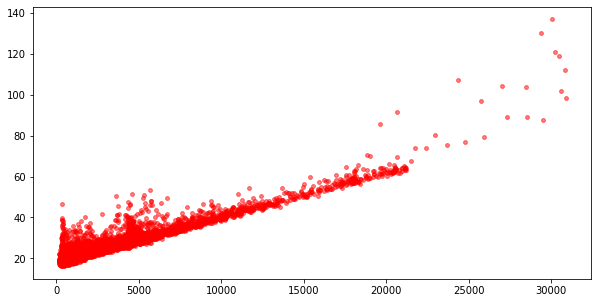

In [105]:
plt.figure(figsize=(10,5))
plt.scatter(fore_ground_points_by_frame,td_tc,s = 15, c = 'r',label = 'FSPC',alpha = 0.5)

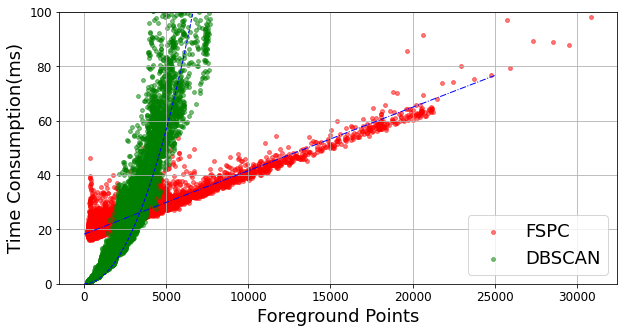

In [107]:
plt.figure(figsize=(10,5))
plt.scatter(fore_ground_points_by_frame,td_tc,s = 15, c = 'r',label = 'FSPC',alpha = 0.5)
plt.scatter(fore_ground_points_by_frame,db_tc,s = 15, c = 'g',label = 'DBSCAN',alpha = 0.5)
x = np.arange(25000)
a,b,c = np.polyfit(fore_ground_points_by_frame,db_tc,2)
y_db = a*x**2 + b
a,b = np.polyfit(fore_ground_points_by_frame,td_tc,1)
y_td = a*x + b
plt.plot(x,y_db,c = 'b',linewidth = 1, linestyle = 'dashed')
plt.plot(x,y_td,c = 'b',linewidth = 1, linestyle = '-.')
plt.grid()
plt.ylabel('Time Consumption(ms)',fontsize = 18)
plt.xlabel('Foreground Points',fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 18)
plt.ylim(0,100)
plt.savefig(r'C:\Users\zhChe\OneDrive - nevada.unr.edu\Presentation\trb\4.tif',dpi = 300)
plt.show()

Generating Threshold Map


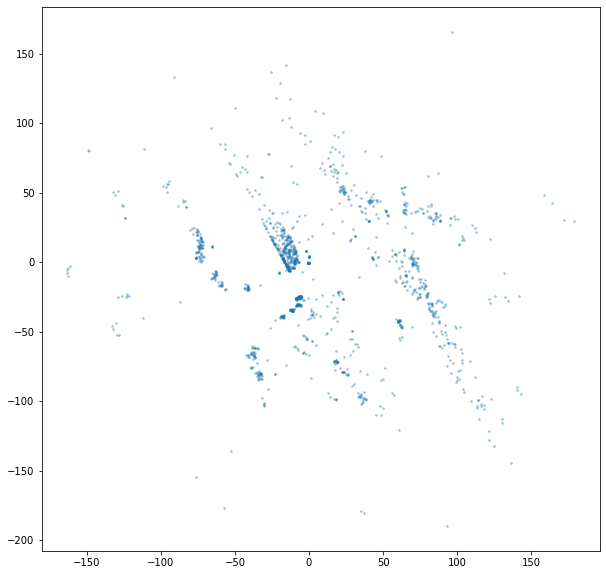

d: 1 thred_s: 0.15 Points: 1471
Generating Threshold Map


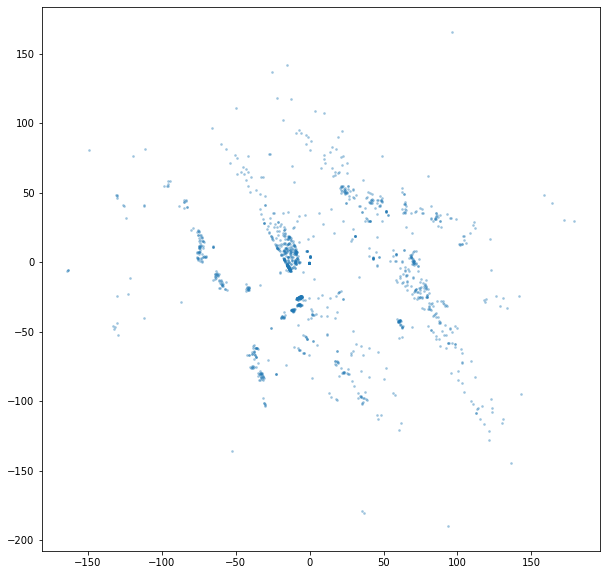

d: 1 thred_s: 0.2 Points: 1360
Generating Threshold Map


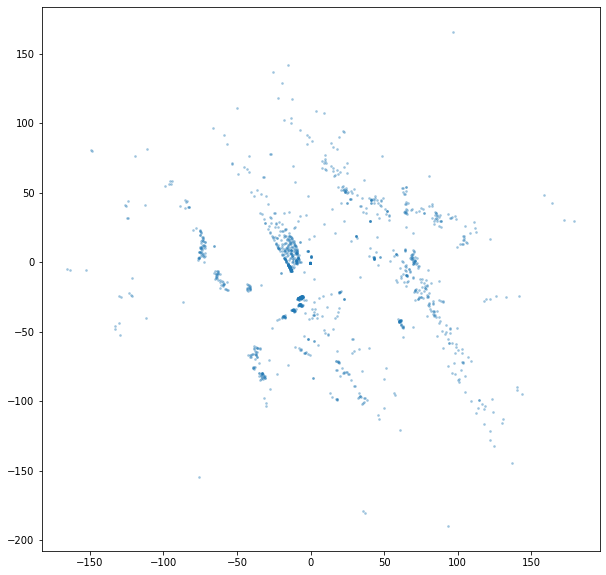

d: 1 thred_s: 0.3 Points: 1306
Generating Threshold Map


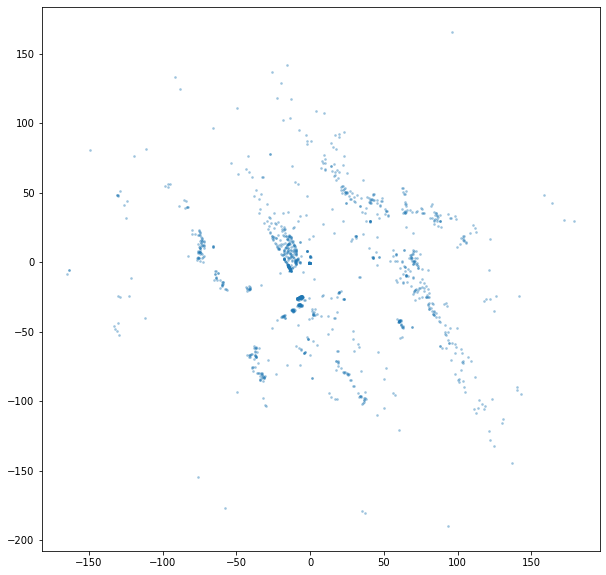

d: 1 thred_s: 0.4 Points: 1237
Generating Threshold Map


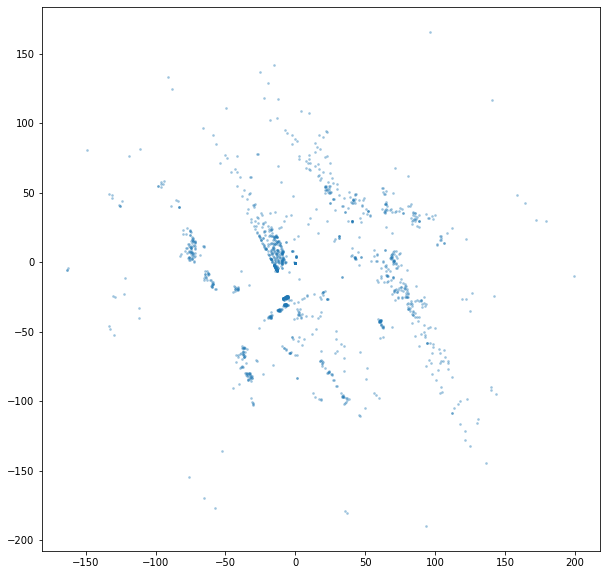

d: 1 thred_s: 0.5 Points: 1360
Generating Threshold Map


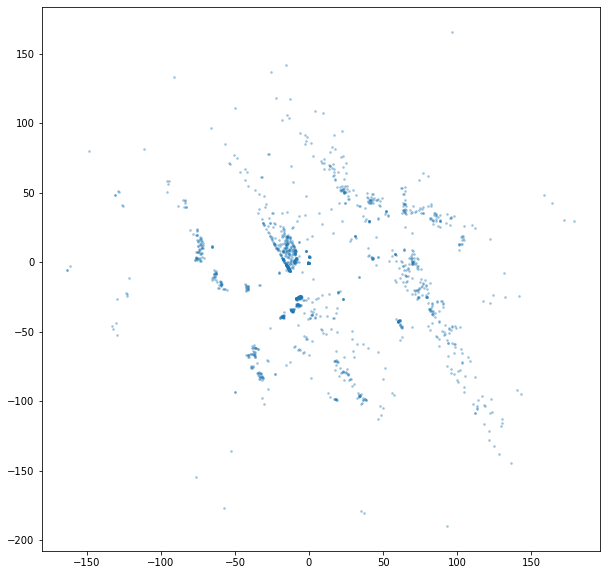

d: 1.2 thred_s: 0.15 Points: 1443
Generating Threshold Map


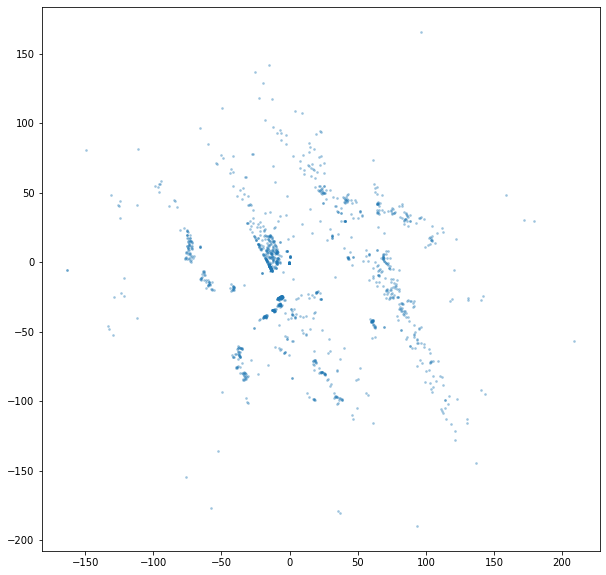

d: 1.2 thred_s: 0.2 Points: 1386
Generating Threshold Map


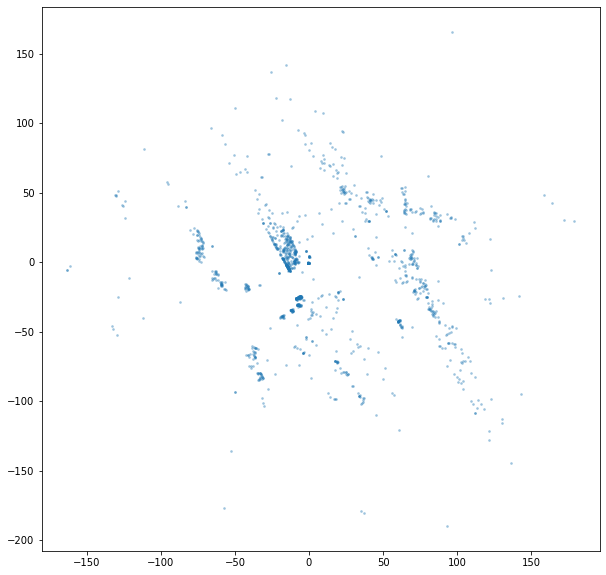

d: 1.2 thred_s: 0.3 Points: 1325
Generating Threshold Map


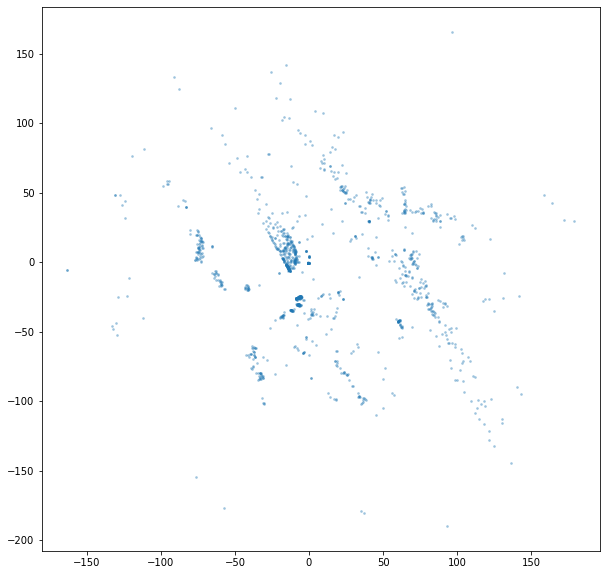

d: 1.2 thred_s: 0.4 Points: 1233
Generating Threshold Map


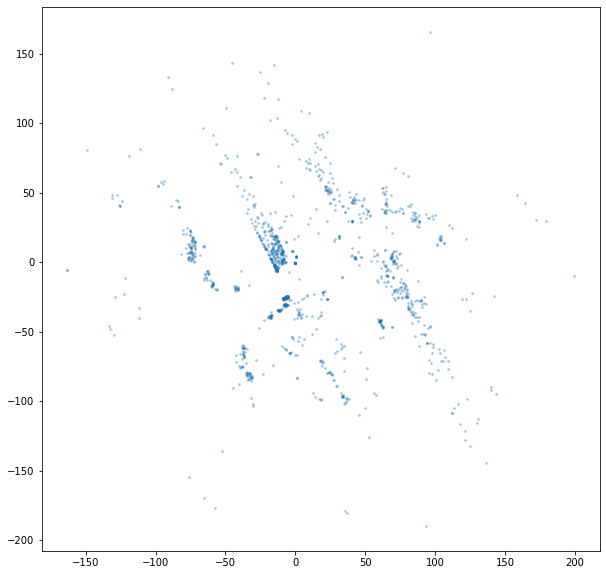

d: 1.2 thred_s: 0.5 Points: 1334
Generating Threshold Map


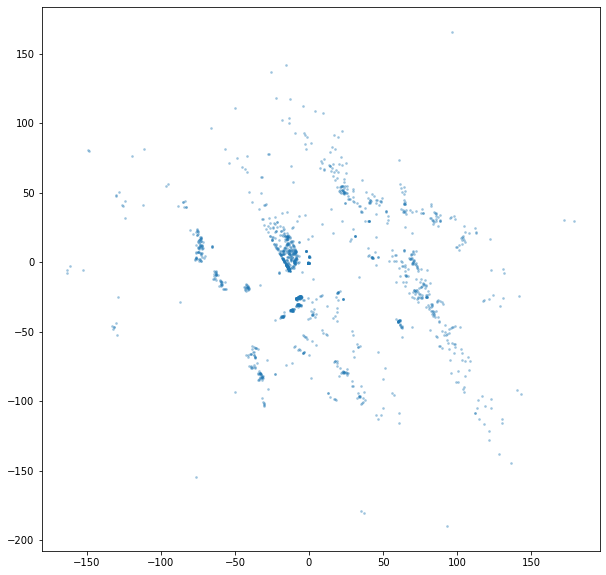

d: 1.5 thred_s: 0.15 Points: 1448
Generating Threshold Map


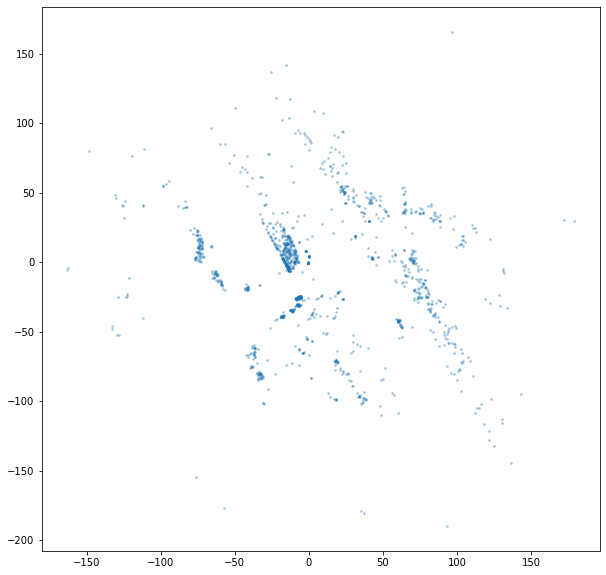

d: 1.5 thred_s: 0.2 Points: 1437
Generating Threshold Map


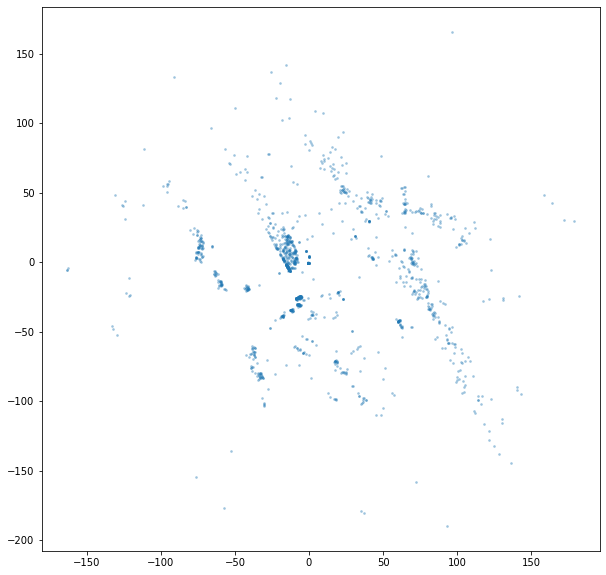

d: 1.5 thred_s: 0.3 Points: 1354
Generating Threshold Map


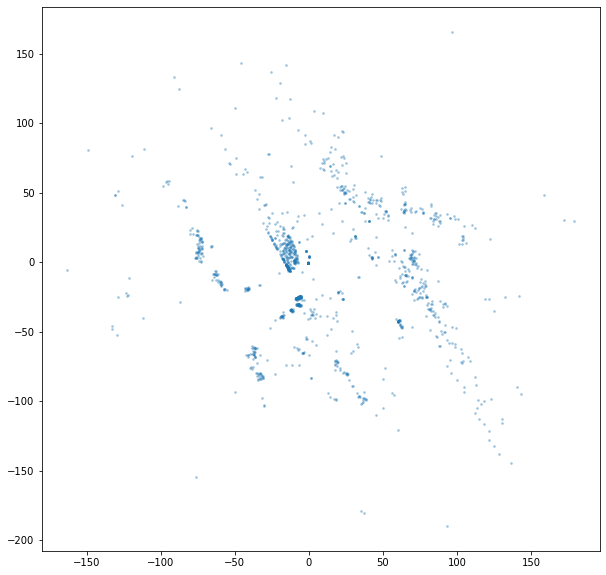

d: 1.5 thred_s: 0.4 Points: 1260
Generating Threshold Map


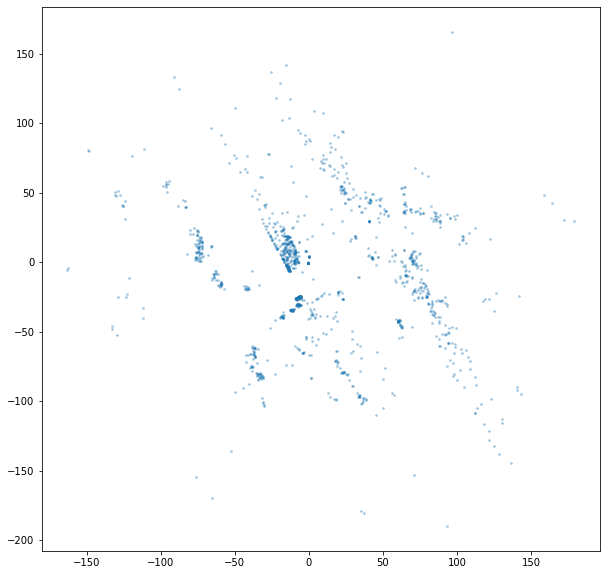

d: 1.5 thred_s: 0.5 Points: 1340
Generating Threshold Map


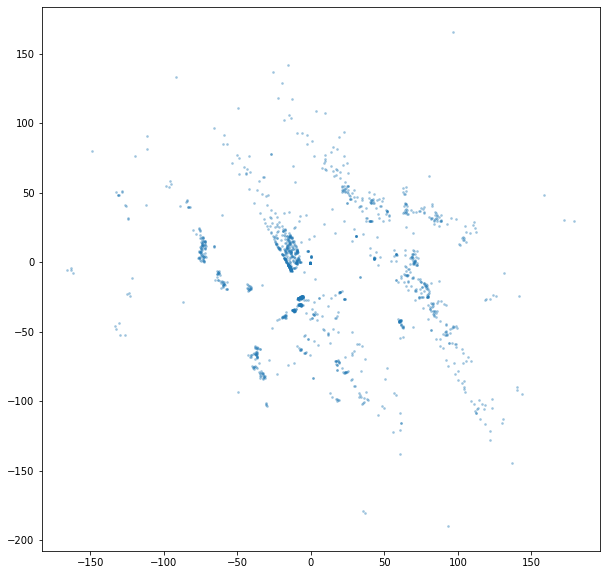

d: 2 thred_s: 0.15 Points: 1462
Generating Threshold Map


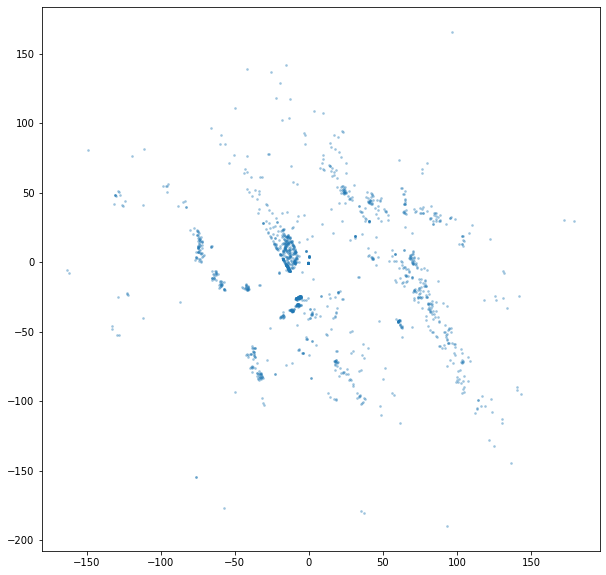

d: 2 thred_s: 0.2 Points: 1460
Generating Threshold Map


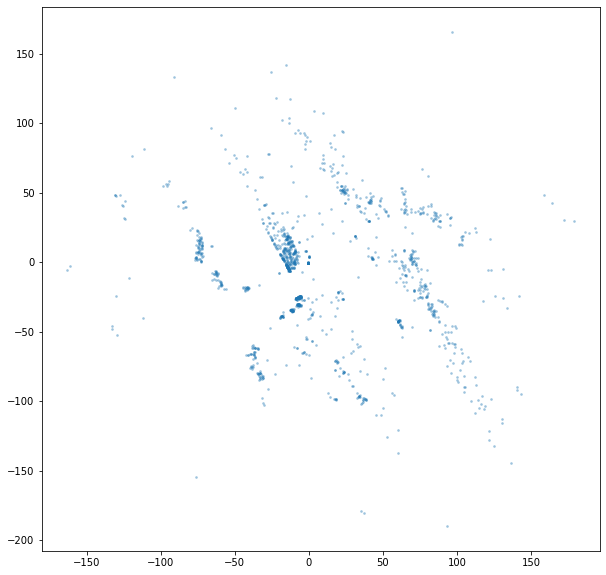

d: 2 thred_s: 0.3 Points: 1378
Generating Threshold Map


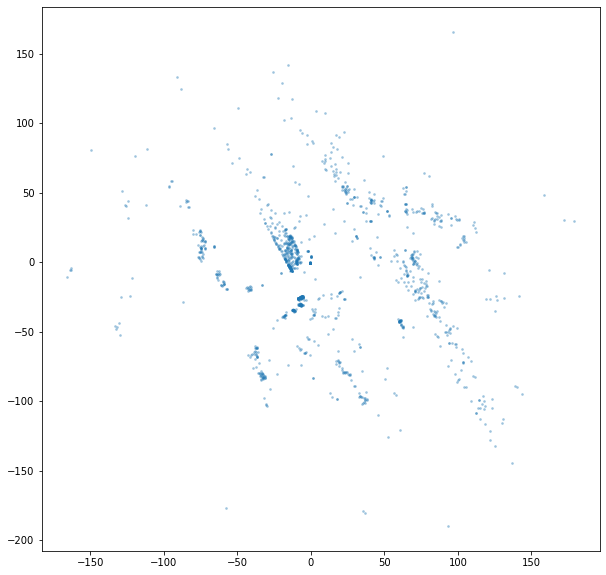

d: 2 thred_s: 0.4 Points: 1303
Generating Threshold Map


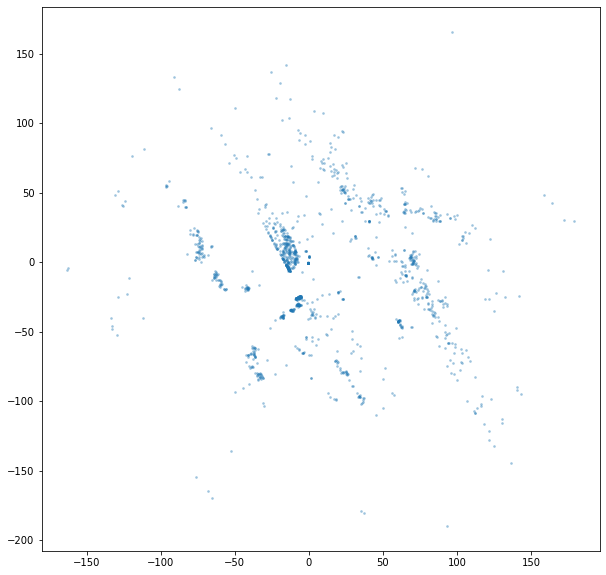

d: 2 thred_s: 0.5 Points: 1355


In [51]:
for d in [1,1.2,1.5,2]:
    for thred_s in [0.15,0.2,0.3,0.4,0.5]:
        collector.gen_thredmap(d = d,thred_s = thred_s,N = 10,delta_thred = 1e-3,step = 0.1)
        db = Raster_DBSCAN(window_size=(5,13),eps = 1.7, min_samples= 17, Td_map_szie=threshold_map.shape)   
        Td_map = collector.aggregated_map[0]
        Foreground_map = (Td_map < collector.thred_map)&(Td_map != 0)
        Background_map = (Td_map >= collector.thred_map)&(Td_map != 0)
        pcd = get_pcd_colored_filtered(Td_map,Labeling_map,Foreground_map)
        points = np.asarray(pcd.points)
        plt.figure(figsize=(10,10))
        plt.scatter(points[:,0],points[:,1],s = 3,alpha = 0.3)
        plt.show()
        print('d:',d,'thred_s:',thred_s,'Points:',len(points))

In [37]:
Td_map = collector.aggregated_map[1500]
Foreground_map = (Td_map < collector.thred_map)&(Td_map != 0)
Labeling_map = db.fit_predict(Td_map= Td_map,Foreground_map=Foreground_map)
Background_map = (Td_map >= collector.thred_map)&(Td_map != 0)
pcd = get_pcd_colored_filtered(Td_map,Labeling_map,Foreground_map)
draw(pcd,height=1000,width=1000)

WebVisualizer(window_uid='window_10')